# SuperstoreSalesPredictor

This Jupyter Notebook analyzes Superstore sales data made available on [Kaggle](https://www.kaggle.com/jr2ngb/superstore-data).  This machine learning sales predictor uses time series analysis to precict a year of sales.  It was created for INFO 659 at Drexel University for the Fall 2021-2022 Quarter.  This `.ipynb` file -- and all relevant documentation -- is available on [Github](https://github.com/zachcarlson/SuperstoreSalesPredictor)

The `SuperstoreSalesPredictor` project was coded in both Python and R.

## Group Information

### Team Members:

- Zach Carlson, zc378@drexel.edu
- Sarah Haley, slh54@drexel.edu
- Nancy Melucci, njm99@drexel.edu

## Importing Data and Preprocessing
### Import Packages

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
FILE_PATH = "/content/drive/MyDrive/Grad School/INFO 659/SuperstoreSalesPredictor/data/superstore_dataset2011-2015.csv" #if using google colab
# FILE_PATH = "./data/superstore_dataset2011-2015.csv" #if using Jupyter notebook

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('max_columns', 25) #some columns will be truncated otherwise, setting to number of columns in sales

In [20]:
def daily_data(data):
    daily_data = data.copy()
    daily_data.date = daily_data.date.apply(lambda x: str(x)[:-3])
    daily_data = daily_data.groupby('date')['sales'].sum().reset_index()
    daily_data.date = pd.to_datetime(monthly_data.date)
    return monthly_data

### Import Data and inspect dataset

In [21]:
sales_raw = pd.read_csv(FILE_PATH, 
                    encoding = "latin")

In [22]:
sales_raw.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,42433,AG-2011-2040,1/1/2011,6/1/2011,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,Algeria,NaN,Africa,Africa,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium
1,22253,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,NaN,APAC,Oceania,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium
2,48883,HU-2011-1220,1/1/2011,5/1/2011,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,Hungary,NaN,EMEA,EMEA,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,High
3,11731,IT-2011-3647632,1/1/2011,5/1/2011,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,Sweden,NaN,EU,North,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.055,4.82,High
4,22255,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,NaN,APAC,Oceania,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.770,4.70,Medium


In [23]:
sales_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Postal Code     9994 non-null   float64
 12  Market          51290 non-null  object 
 13  Region          51290 non-null  object 
 14  Product ID      51290 non-null  object 
 15  Category        51290 non-null  object 
 16  Sub-Category    51290 non-null  object 
 17  Product Name    51290 non-null 

In [24]:
sales_raw.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Shipping Cost
count,51290.00000,9994.000000,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,25645.50000,55190.379428,246.490581,3.476545,0.142908,28.610982,26.375915
std,14806.29199,32063.693350,487.565361,2.278766,0.212280,174.340972,57.296804
min,1.00000,1040.000000,0.444000,1.000000,0.000000,-6599.978000,0.000000
25%,12823.25000,23223.000000,30.758625,2.000000,0.000000,0.000000,2.610000
50%,25645.50000,56430.500000,85.053000,3.000000,0.000000,9.240000,7.790000
75%,38467.75000,90008.000000,251.053200,5.000000,0.200000,36.810000,24.450000
max,51290.00000,99301.000000,22638.480000,14.000000,0.850000,8399.976000,933.570000


#### Observations:

- There are 51,290 instances with 24 features.
- Dates are in `DD/MM/YYYY` format.
- Features are mostly `object`, with five `float64` and two `int64` features.  Datetime columns need to be converted accordingly.
- There are 41,296 missing values from `Postal Code`.  This is because the `Postal Code` is only present for U.S. purchases.

We'll save a copy of `sales_raw` in case we want to utilize `Postal Code` later.  However, for sales-focused prediction, it won't be necessary:

In [25]:
sales = sales_raw.copy()
sales = sales.drop("Postal Code", axis = 1) #axis=1 for column
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Market          51290 non-null  object 
 12  Region          51290 non-null  object 
 13  Product ID      51290 non-null  object 
 14  Category        51290 non-null  object 
 15  Sub-Category    51290 non-null  object 
 16  Product Name    51290 non-null  object 
 17  Sales           51290 non-null 

In [26]:
#convert datetime columns to datetime objects
sales['Order Date'] = pd.to_datetime(sales['Order Date'])
sales['Ship Date'] = pd.to_datetime(sales['Ship Date'])
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  datetime64[ns]
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   City            51290 non-null  object        
 9   State           51290 non-null  object        
 10  Country         51290 non-null  object        
 11  Market          51290 non-null  object        
 12  Region          51290 non-null  object        
 13  Product ID      51290 non-null  object        
 14  Category        51290 non-null  object        
 15  Su

In [27]:
#Get only order date, sales, and profit
sales = sales.loc[:, ["Order Date", "Sales", "Profit"]]

#Set date column to index
sales.set_index('Order Date', inplace = True)

In [28]:
#confirm we have a Datetime series object
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51290 entries, 2011-01-01 to 2014-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   51290 non-null  float64
 1   Profit  51290 non-null  float64
dtypes: float64(2)
memory usage: 1.2 MB
None


## Time Series Analysis

Let's start by visualizing the `Sales` and `Profit` from 2011-2015:

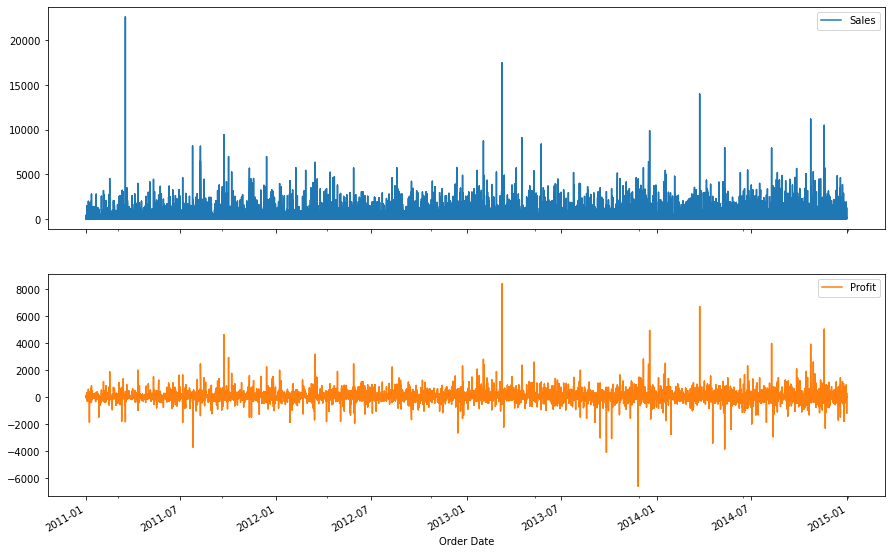

In [32]:
sales.plot(subplots = True)
plt.gcf().set_size_inches(15, 10)
plt.show()

Let's see how the data compares year to year by overlapping the time series data:

In [44]:
#Create empty dataframe to store yearly data
yearly_sales = pd.DataFrame()

for year in ["2011", "2012", "2013", "2014"]:
  sales_per_year = sales.loc[year, ["Sales"]].reset_index(drop = True)
  sales_per_year.rename(columns={"Sales": year}, inplace = True)
  yearly_sales = pd.concat([yearly_sales, sales_per_year], axis=1)

yearly_sales

,2011,2012,2013,2014
0,408.300,593.9895,1649.214,677.4075
1,120.366,151.9200,1358.280,846.2880
2,66.120,200.1600,728.568,332.1630
3,44.865,192.8800,2189.520,156.5120
4,113.670,94.0200,1362.060,159.7680
...,...,...,...,...
17526,NaN,NaN,NaN,13.9040
17527,NaN,NaN,NaN,3.9900
17528,NaN,NaN,NaN,26.4000
17529,NaN,NaN,NaN,7.1200


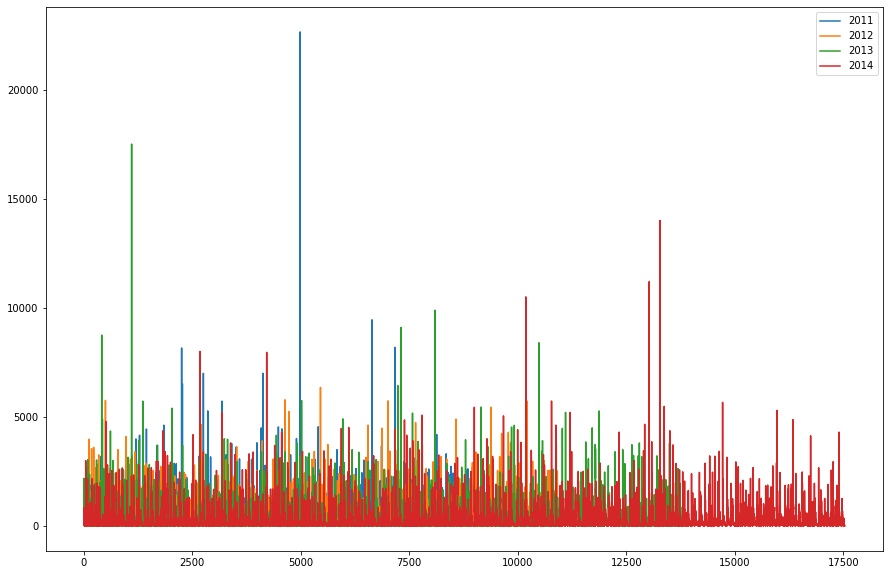

In [57]:
yearly_sales.plot()
plt.gcf().set_size_inches(15, 10)
plt.show()

In [52]:
sales = sales.groupby("Order Date").sum()
sales

,Sales,Profit
Order Date,,
2011-01-01,808.56300,198.87300
2011-01-02,2455.67000,603.47360
2011-01-03,12565.76630,1905.15390
2011-01-04,2582.80100,-308.78740
2011-01-06,11480.49270,2460.25360
...,...,...
2014-12-27,13421.26376,-916.64004
2014-12-28,1647.17400,81.06380
2014-12-29,25109.28878,2046.20678


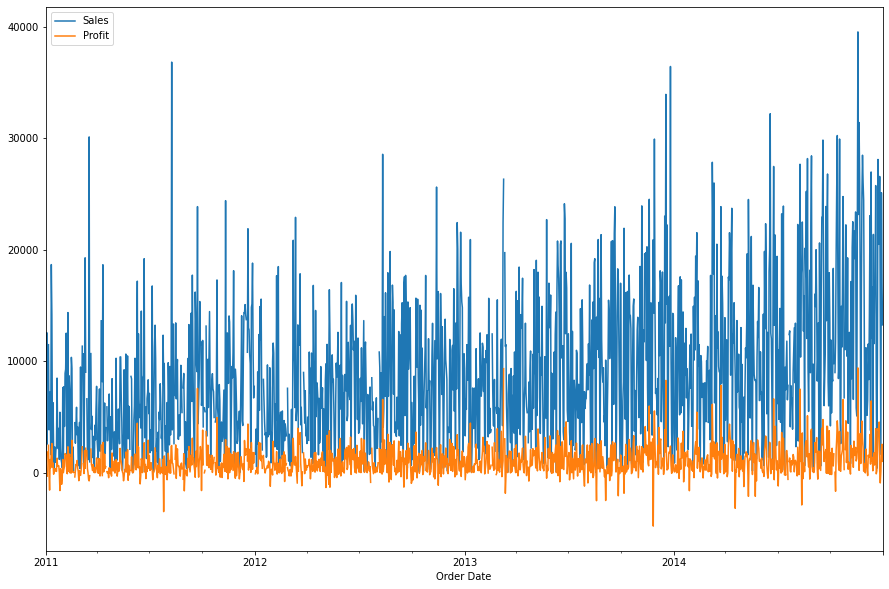

In [71]:
sales.asfreq('D').plot()
plt.gcf().set_size_inches(15, 10)
plt.show()

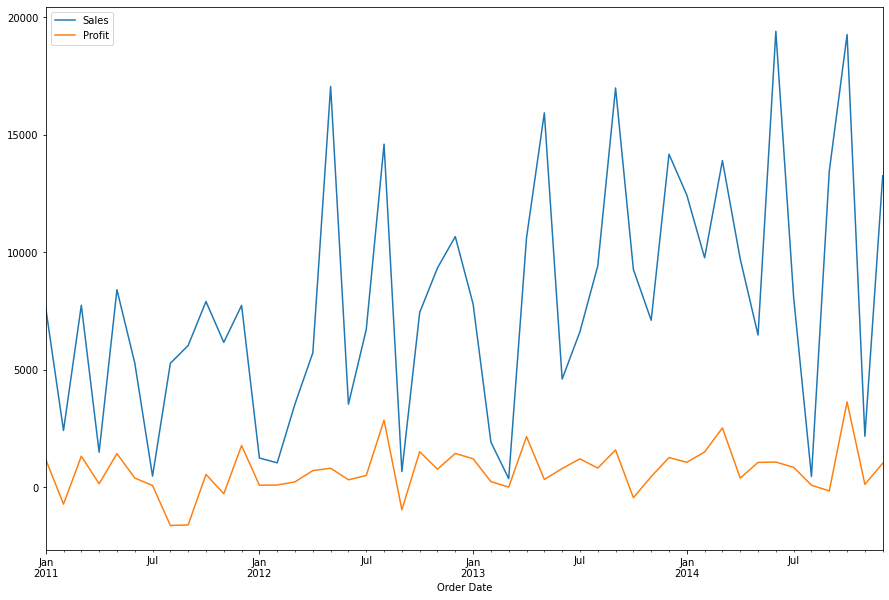

In [70]:
sales.asfreq('M').plot()
plt.gcf().set_size_inches(15, 10)
plt.show()

## Conclusions and Summary